# Modèle `MCLES`

## Chargements des datasets prétraitées

In [2]:
from datasets.load_to_experiment import load_multiple_features, load_msrcv1
datasets = []

### dataset multiple features

In [3]:
datasets.append(load_multiple_features("mlces", "datasets/"))

### dataset MSRC-v1

https://github.com/ManshengChen/MCLES

In [4]:
dataset_msrc_v1 = load_msrcv1("mlces", "datasets/")
datasets.append(dataset_msrc_v1)


## Métriques

In [28]:
from metriques import clusteringMeasure

## Implémentations et expérimentations

### Code de référence ( écrit en matlab)
https://github.com/ManshengChen/MCLES

vous devez installé l'outil opensource `octave`, ainsi que son API d'exécution pour python pour pouvoir exécuter le code matlab.

In [16]:
# installation de octave
!apt install octave

E: Impossible d'ouvrir le fichier verrou /var/lib/dpkg/lock-frontend - open (13: Permission non accordée)
E: Impossible d'obtenir le verrou de dpkg (/var/lib/dpkg/lock-frontend). Avez-vous les droits du superutilisateur ?


In [17]:
# installation de l'API
!pip install oct2py

#### Exécution du modèle sur la dataset  `MSRC-v1`

In [ ]:
from oct2py import octave
from sklearn.cluster import KMeans


def mcles_ref(X, k, d=45, maxIters=30, alpha=0.8, beta=0.5, gamma=0.004, epsilon=0.01, maxItersForKmeans=1000, nInitForKmeans=20, verbose=False, path_ref_dir = './MCLES-master/MCLES Code/'):
    
    octave.addpath(octave.genpath(path_ref_dir))
    W, H, S, P, obj = octave.feval(
        "MCLES.m", X, k, alpha, beta, d, gamma, maxIters)
    octave.restart()

    # affichage de la fonction de perte
    if verbose:
        for it in range(len(obj)):
            print("iterations {} : Objective function : {}".format(
                it, obj[it]))
    # attribution des observations aux clusters
    kmeans = KMeans(
        n_clusters=k,
        max_iter=maxItersForKmeans,
        n_init=nInitForKmeans,
    )
    kmeans.fit(P)
    labels_clusters = kmeans.labels_
    return {"W": W, "H": H, "S": S, "P": P.real, "labels": labels_clusters, "objs": obj}

        

In [ ]:
# hyper-parametres par défaut
maxIters = 10
alpha = 0.8
beta = 0.4
d = 70
gamma = 0.004

# nombre de clusters
k = 7

# exécution du modèle
result = mcles_ref(X, k, d=45, maxIters=maxIters, alpha=alpha, beta=beta, gamma=gamma,verbose=True)

visualisation de la courbe de convergence

In [ ]:
import matplotlib.pyplot as plt

obj= result["objs"]

plt.xlabel('Itération')
plt.ylabel('obj')
plt.title(' Convergence')
plt.plot(obj)

visualisation de le carte des poids (pour apprecier la projection dans l'ensemble des clusters)

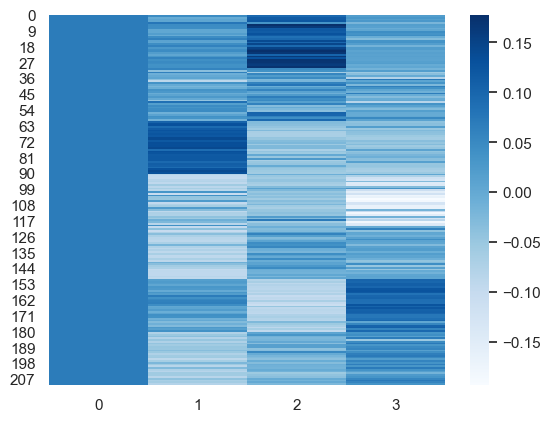

In [ ]:
import seaborn as sns; sns.set()
ax = sns.heatmap(result["H"], cmap="Blues")

cacul des métriques

In [ ]:
labels_clusters = result["labels"]
clusteringMeasure(dataset_msrc_v1["Y"], labels_clusters)

#### experimentations sur toutes les datasets

In [ ]:
metrics_ref = {"dataset": [], "ACC": [], "NMI": [], "PUR": [], }
for dataset in datasets:
    if dataset["can_use_exp"]:
        print('***** Experimentations sur la dataset {} (en cours)'.format(dataset["name"]))
        
        # recuperation des paramètres pour le modèle
        maxIters = dataset["parameters"]["maxIters"]
        alpha = dataset["parameters"]["alpha"]
        beta = dataset["parameters"]["beta"]
        d = dataset["parameters"]["d"]
        gamma = dataset["parameters"]["gamma"]
        k = dataset["parameters"]["k"]
        
        # execution du modèle en utilisant les paramètres
        result = mcles_ref(X, k, d=45, maxIters=maxIters, alpha=alpha, beta=beta, gamma=gamma,verbose=False)
        
        # calcul des métriques
        metrics = clusteringMeasure(dataset_msrc_v1["Y"], result["labels"])
        metrics_ref["dataset"] = dataset["name"]
        metrics_ref["ACC"].append(metrics["ACC"])
        metrics_ref["NMI"].append(metrics["NMI"])
        metrics_ref["PUR"].append(metrics["PUR"])
        print("fin\n")


In [ ]:
metrics_ref = pd.DataFrame(metrics_ref)
metrics_ref.to_json("metrics_ref.json")
metrics_ref

### modèle `MCLES` en python

#### Implémentaion du modèle


In [20]:
!pip install qpsolvers

In [31]:
from numpy import real, argsort
from numpy.linalg import eig

# utils

# permet de retourner les k premieres valeurs propres avec leur vecteurs
# ainsi que toutes les valeurs propres en ordre
def eigs(M, k):
    eigen_values, eigen_vectors = eig(M)
    idx = argsort(real(eigen_values))
    eigen_values = eigen_values[idx]
    eigen_vectors = eigen_vectors[:, idx]

    return eigen_values[:k].real, eigen_vectors[:, :k], eigen_values

In [32]:
from numpy import maximum, sum, tile, array, zeros, dot, eye, sqrt, transpose, mean
from numpy.linalg import solve


def normcol(G):
    # Calcul de la norme des colonnes de G
    norms = maximum(1, sqrt(
        sum(G * G, axis=0)))

    # Division des colonnes de G par leurs normes
    # en créant une matrice G' où G'(ij) = norms(j) pour tout i
    # G_ = np.tile(norms, (G.shape[0], 1))
    return G / tile(norms, (G.shape[0], 1))

# fonction de mise à jour de W
def UpdateW(H, X, W, rho=1, taux=1, maxIters=100, epsilon=1e-6):
    W_ = array(W)
    G = array(W)
    T = zeros(W.shape, dtype=float)
    d = H.shape[0]
    rho_ = rho

    A = transpose(dot(H, H.T) + rho_ * eye(d))
    for it in range(maxIters):
        W_old = W_
        # compute W(t+1)
        B = transpose(dot(X, H.T) + rho_ * (G - T))
        W_ = transpose(solve(A, B))
        # compute G(t+1)
        G = normcol(W_ + T)
        # compute T(t+1)
        T += W_ - G
        # update rho_
        rho_ = rho_ * taux
        error = mean(mean((W_ - W_old)**2))

        if it > 0 and error < epsilon:
            break
    return W_


In [33]:
from numpy import dot, eye
from scipy.linalg import solve_sylvester

# fonction de mise à jour de H
def UpdateH(X, W, S, alpha):
    A = dot(W.T, W)
    B = eye(S.shape[0]) - S
    B = alpha * dot(B, B.T)
    C = dot(W.T, X)
    return solve_sylvester(A, B, C)

In [38]:
from numpy import dot, eye, ones, zeros, maximum
from numpy.linalg import norm

from qpsolvers import solve_qp

# fonction de mise à jour de S
def UpdateS(H, P, alpha=0.001, beta=0.5, gamma=0.004):
    N = H.shape[1]
    bi = zeros(N, dtype=float)

    K = dot(H.T, H)
    Q = K + (beta/alpha) * eye(K.shape[0], dtype=float)
    Q = (Q + Q.T)/2

    # pour les contraintes linéaire

    A = ones((N, N), dtype=float)
    ones_ = ones(N, dtype=float)  # uh , b
    zeros_ = zeros(N, dtype=float)  # lh

    S_ = zeros((N, N))
    for i in range(N):

        # calcul de bi
        for j in range(N):
            bi[j] = norm(P[i] - P[j])**2
        
        bi = maximum(bi.real, 0)
        
        # calcul de r
        r = -2*K[i, :] + (gamma / (2*alpha))*bi

        # calcul de S:i
        Si = solve_qp(Q, r, None, None, A, ones_, zeros_, ones_, solver="osqp")
        if Si is not None:
            S_[:, i] = Si
    return S_


In [39]:
from numpy import sum, diag

# permet de mettre à jour P
def updateP(S, k):
    N = S.shape[0]
    Z = (S + S.T) / 2
    D = diag(sum(Z, axis=1))
    L = D - Z

    #L = np.maximum(L, L.T)
    _, P, _ = eigs(L, k)
    return L, P

In [40]:
from numpy import sqrt, concatenate, zeros, dot, sum, trace, sqrt
from numpy.random import rand
from sklearn.cluster import KMeans

def mcles(X, k, d=45, maxIters=30, alpha=0.8, beta=0.5, gamma=0.004, epsilon=0.01, maxItersForKmeans=1000, nInitForKmeans=20, verbose=False):
    # nombre de vues
    V = len(X)
    # nombre d'observations
    N = X[0].shape[1]

    for i in range(V):
        # normalisation de chaque observation (on transforme les vecteurs d'observations en leurs vecteurs unitaires)
        temp = sqrt(sum(X[i]**2, axis=0))
        X[i] /= temp

    X_ = concatenate(X, axis=0)
    D = [X[i].shape[0] for i in range(V)]
    SD = sum(D)
    W = zeros((SD, d), dtype=float)
    H = rand(d, N)
    S = zeros((N, N), dtype=float)
    P = rand(N, k)

    # tableau des valeurs de la fonction objective
    objectives = []

    for it in range(maxIters):
        # > update W
        W = UpdateW(H, X_, W)
        # > update H
        H = UpdateH(X_, W, S, alpha)
        # > update S
        S = UpdateS(H, P, alpha, beta, gamma)
        # > update P
        L, P = updateP(S, k)

        # > vérification de la convergence
        #  calcul et enregistrement des valeurs de la fonction objective
        obj = sum((X_ - dot(W, H))**2) + alpha * sum((H - dot(H, S))**2) \
            + beta * sum(S**2) + gamma * \
            trace(dot(dot(P.T, L), P))
        objectives.append(obj.real)
        if verbose:
            print("iterations {} : Objective function : {}".format(it, obj))
        if it > 0 and (abs(obj - objectives[it-1])/objectives[it-1]) < epsilon:
            break

    kmeans = KMeans(
        n_clusters=k,
        n_init=nInitForKmeans,
        max_iter=maxItersForKmeans,
    )
    kmeans.fit(P.real)
    labels_clusters = kmeans.labels_

    return {"W": W, "H": H, "S": S, "P": P.real, "labels": labels_clusters, "objs": objectives}


#### Exécution du modèle sur la dataset  `MSRC-v1`

In [41]:
# hyper-parametres par défaut
maxIters = 10
alpha = 0.8
beta = 0.4
d = 70
gamma = 0.004

# nombre de clusters
k = 7

# exécution du modèle
result = mcles(dataset_msrc_v1["X"], k, alpha=alpha, beta=beta, d=d, gamma=gamma, maxIters=maxIters, verbose=True)

/home/mbe/anaconda3/lib/python3.10/site-packages/qpsolvers/conversions/ensure_sparse_matrices.py:38: UserWarning: Converted P to scipy.sparse.csc.csc_matrix
For best performance, build P as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  warnings.warn(
/home/mbe/anaconda3/lib/python3.10/site-packages/qpsolvers/conversions/ensure_sparse_matrices.py:38: UserWarning: Converted A to scipy.sparse.csc.csc_matrix
For best performance, build A as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  warnings.warn(


iterations 0 : Objective function : 491.8282581090328
iterations 1 : Objective function : 23.46295925417057
iterations 2 : Objective function : 22.11649367521377
iterations 3 : Objective function : 22.0304502610273


visualisation de la courbe de convergence

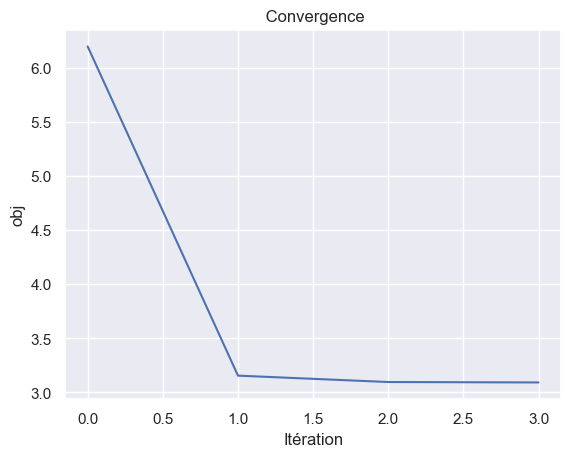

In [42]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
obj = result["objs"]
plt.xlabel('Itération')
plt.ylabel('obj')
plt.title(' Convergence')
plt.plot(np.log(obj))

visualisation des observations dans l'espace des clusters

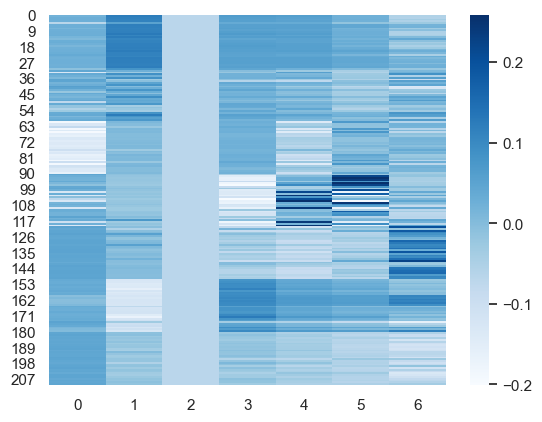

In [43]:
import seaborn as sns; sns.set()
ax = sns.heatmap(result["P"], cmap="Blues")

cacul des métriques

In [44]:
clusteringMeasure(dataset_msrc_v1["Y"], result['labels'])

{'ACC': 0.7523809523809524,
 'NMI': 0.7439339204503798,
 'PUR': 0.7857142857142857}

#### experimentations sur toutes les datasets

In [45]:
metrics_me = {"dataset": [], "ACC": [], "NMI": [], "PUR": [], }
for dataset in datasets:
    if dataset["can_use_exp"]:
        print('***** Experimentations sur la dataset {} (en cours)'.format(dataset["name"]))
        
        # recuperation des paramètres pour le modèle
        maxIters = dataset["parameters"]["maxIters"]
        alpha = dataset["parameters"]["alpha"]
        beta = dataset["parameters"]["beta"]
        d = dataset["parameters"]["d"]
        gamma = dataset["parameters"]["gamma"]
        k = dataset["parameters"]["k"]
        
        # execution du modèle en utilisant les paramètres
        result = mcles(dataset["X"], k, alpha=alpha, beta=beta, d=d, gamma=gamma, maxIters=maxIters)
        
        # calcul des métriques
        result = clusteringMeasure(dataset_msrc_v1["Y"], result["labels"])
        metrics_me["dataset"] = dataset["name"]
        metrics_me["ACC"].append(result["ACC"])
        metrics_me["NMI"].append(result["NMI"])
        metrics_me["PUR"].append(result["PUR"])
        print("fin\n")


***** Experimentations sur la dataset MSRC-v1 (en cours)


/home/mbe/anaconda3/lib/python3.10/site-packages/qpsolvers/conversions/ensure_sparse_matrices.py:38: UserWarning: Converted P to scipy.sparse.csc.csc_matrix
For best performance, build P as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  warnings.warn(
/home/mbe/anaconda3/lib/python3.10/site-packages/qpsolvers/conversions/ensure_sparse_matrices.py:38: UserWarning: Converted A to scipy.sparse.csc.csc_matrix
For best performance, build A as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  warnings.warn(


fin



In [46]:
metrics_me = pd.DataFrame(metrics_me)
metrics_me.to_json("metrics_me.json")
metrics_me

,dataset,ACC,NMI,PUR
0,MSRC-v1,0.757143,0.730866,0.785714
